<h1 align="center">Analysis of the Amazon dataset of book reviews</h1>

The aim was to process the semantic analysis of Ukrainian texts, so the collection of positive and negative reviews was translated into Ukrainian using Google Translate.

To get started, we import all the libraries we need:

In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

%matplotlib inline

Also let's write a style for alignment in the middle of all graphs, images, etc:

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Next, since our reviews are in XML format, we need to process each line to get the value from the tags.

**Note**: 
* **`errors='ignore'`** used to skip all possible incorrect characters in our documents;

* **`readLines`** return all lines in the file, as a list where each line is an item in the list object.

In [3]:
test_read = open('data/positive.review', 'r', encoding='utf8', errors='ignore').readlines()
for i in range(85):
    print(test_read[i])

<reviews>

<review>

<unique_id>

0375416811: owner_of_chick_lit: erin_oakes_ "avid_reader"

</unique_id>

<unique_id>

1521 рік

</unique_id>

<asin>

0375416811

</asin>

<product_name>

Щоденник Бріджит Джонс: Книги: Хелен Філдінг, Трейсі Беннет

</product_name>

<product_type>

книги

</product_type>

<product_type>

книги

</product_type>

<helpful>



</helpful>

<rating>

5.0

</rating>

<title>

Засновник Чик-літ

</title>

<date>

24 серпня 2006 р

</date>

<reviewer>

Ерін Оукс "завзятий читач"

</reviewer>

<reviewer_location>

Центральна ПА

</reviewer_location>

<review_text>

Бріджит Джонс, сучасна жінка, блискуча і не знає цього, схильна до нещасних випадків та безладів, але їм вдається вийти з них.



Це книга, яка розпочала все з лихоманки, що запалюється. Бріджит Джонс - мій герой!

</review_text>

</review>

<review>

<unique_id>

188105201X: відмінний_ресурс_для_принципів!: Onickre@mail.milwaukee.k12.wi.us

</unique_id>

<unique_id>

3294

</unique_id>

<asin>

1881

In our directory with training sets we have two files - with positive and negative reviews, each of these files contains 1000 unprocessed reviews. Let's check this:

In [4]:
pos_reviews = open('data/positive.review', 'r', encoding='utf8', errors='ignore').read()
neg_reviews = open('data/negative.review', 'r', encoding='utf8', errors='ignore').read()

pos_rev_tree = ET.fromstring(pos_reviews)
neg_rev_tree = ET.fromstring(neg_reviews)

pos_tags = pos_rev_tree.findall('review')
neg_tags = neg_rev_tree.findall('review')

print('\nNumber of Positive Reviews:', len(pos_tags),
      '\nNumber of Positive Reviews:', len(neg_tags))


Number of Positive Reviews: 1000 
Number of Positive Reviews: 1000


**Note:** 
* **`fromstring()`** parses XML from a string directly into an Element, which is the root element of the parsed tree;
* **`findall() `** finds all elements with a tag which are direct children of the current element (`reviews`).

<h2 align="center">XML Parse</h2>

Now we will try to parse our XML file at a basic level. We will create a dictionary from the lists. Each list will contain certain tags and their content for single review. We already have a tree with positive and negative reviews, so all that remains is to parse it. But before that, let's list all the tags in our xml files so we don't have to repeat:

In [5]:
REVIEW_TAGS = ['unique_id', 'asin', 'product_name', 'helpful', 'rating', 'title',
               'date', 'reviewer', 'reviewer_location', 'review_text']

In [6]:
def parseXML(xml_reviews):
    reviews = {}
    count = 0

    for item in xml_reviews:
        count += 1
        rev_name = 'review' + str(count)
        reviews[rev_name] = [
            REVIEW_TAGS[0] + ' | ' + item.find(REVIEW_TAGS[0]).text.strip(),
            REVIEW_TAGS[1] + ' | ' + item.find(REVIEW_TAGS[1]).text.strip(),
            REVIEW_TAGS[2] + ' | ' + item.find(REVIEW_TAGS[2]).text.strip(),
            REVIEW_TAGS[3] + ' | ' + item.find(REVIEW_TAGS[3]).text.strip(),
            REVIEW_TAGS[4] + ' | ' + item.find(REVIEW_TAGS[4]).text.strip(),
            REVIEW_TAGS[5] + ' | ' + item.find(REVIEW_TAGS[5]).text.strip(),
            REVIEW_TAGS[6] + ' | ' + item.find(REVIEW_TAGS[6]).text.strip(),
            REVIEW_TAGS[7] + ' | ' + item.find(REVIEW_TAGS[7]).text.strip(),
            REVIEW_TAGS[8] + ' | ' + item.find(REVIEW_TAGS[8]).text.strip(),
            REVIEW_TAGS[9] + ' | ' + item.find(REVIEW_TAGS[9]).text.strip()
        ]

    return reviews

Now let's actually create dictionaries with the required values and check output:

In [7]:
pos_reviews_dict = parseXML(pos_tags)
neg_reviews_dict = parseXML(neg_tags)
pos_reviews_dict['review1']

['unique_id | 0375416811: owner_of_chick_lit: erin_oakes_ "avid_reader"',
 'asin | 0375416811',
 'product_name | Щоденник Бріджит Джонс: Книги: Хелен Філдінг, Трейсі Беннет',
 'helpful | ',
 'rating | 5.0',
 'title | Засновник Чик-літ',
 'date | 24 серпня 2006 р',
 'reviewer | Ерін Оукс "завзятий читач"',
 'reviewer_location | Центральна ПА',
 'review_text | Бріджит Джонс, сучасна жінка, блискуча і не знає цього, схильна до нещасних випадків та безладів, але їм вдається вийти з них.\n\nЦе книга, яка розпочала все з лихоманки, що запалюється. Бріджит Джонс - мій герой!']

Next, we will turn our reviews dictionaries into a Pandas DataFrame:

In [8]:
def dict_to_dataframe(reviews_dict):
    # prepare our dataframe for the data
    df = pd.DataFrame(columns=REVIEW_TAGS)
    count = 0
    for val in reviews_dict.values():
        df.loc[count] = [
            val[0].split("|")[1], val[1].split("|")[1],
            val[2].split("|")[1], val[3].split("|")[1],
            val[4].split("|")[1], val[5].split("|")[1],
            val[6].split("|")[1], val[7].split("|")[1],
            val[8].split("|")[1], val[9].split("|")[1]
        ]

        count = count + 1

    return df

pos_books = dict_to_dataframe(pos_reviews_dict)
neg_books = dict_to_dataframe(neg_reviews_dict)

Let's check for correctness:

In [9]:
pos_books.head(n=3)

,unique_id,asin,product_name,helpful,rating,title,date,reviewer,reviewer_location,review_text
0,"0375416811: owner_of_chick_lit: erin_oakes_ ""...",0375416811,"Щоденник Бріджит Джонс: Книги: Хелен Філдінг,...",,5.0,Засновник Чик-літ,24 серпня 2006 р,"Ерін Оукс ""завзятий читач""",Центральна ПА,"Бріджит Джонс, сучасна жінка, блискуча і не з..."
1,188105201X: відмінний_ресурс_для_принципів!: ...,188105201X,Лідерство та нова наука: вивчення організації...,3 з 3,5.0,Чудовий ресурс для директорів!,6 липня 1999 р,ONICKRE@mail.milwaukee.k12.wi.us,"Мілуокі, штат Вісконсін",Я замовляю копії для всіх 23 директорів серед...
2,0634079190: fun_to_play: michael_p._nolan,0634079190,Avenue Q - мюзикл (аранжування на фортепіано ...,,5.0,Забавно грати,15 вересня 2005 р,Майкл П. Нолан,"Таллахассі, Флорида, США",Як випадковий гравець на фортепіано та фанат ...


In [10]:
neg_books.head(n=3)

,unique_id,asin,product_name,helpful,rating,title,date,reviewer,reviewer_location,review_text
0,0743518144: ok ~ _but_i_think_the_keirsey_tem...,0743518144,Тепер відкрийте свої сильні сторони: Книги: М...,7 з 8,2.0,"Гаразд ~ але я думаю, що тест на спокій Керсі...",10 вересня 2006 р,"Джен ""правдивець""","DE, США","Ця книга має свої добрі сторони. Якщо що, це ..."
1,0895261715: відпустка_продажу_консервативізму...,0895261715,Консервативний розум: від Берка до Еліота: Кн...,32 із 95,2.0,Відштовхувальний продаж консерватизму,18 серпня 2005 р,Е. Девід Свон,"Південний Евклід, штат Огайо, США",Фаталістичний погляд на консерватизм Кірк вис...
2,0787978949: i_had_a_bad_feeling_about_this! _...,0787978949,Християнська мудрість майстрів-джедаїв: Книги...,6 з 12,1.0,У мене було погане відчуття з цього приводу! ...,4 грудня 2005 р,З. Фу,"Нью-Йорк, Нью-Йорк","Мене заінтригував титул, який нібито пов'язує..."


Everything is correct, wonderful! Let's generate descriptive statistics. Pandas Dataframe descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values. We will also check whether the number of positive and negative reviews has been preserved:

In [11]:
print('\nNumber of Positive Reviews (Dataframe):', len(pos_books),
      '\nNumber of Negative Reviews (Dataframe):', len(neg_books))

pos_books.describe()
neg_books.describe()


Number of Positive Reviews (Dataframe): 1000 
Number of Negative Reviews (Dataframe): 1000


,unique_id,asin,product_name,helpful,rating,title,date,reviewer,reviewer_location,review_text
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,997,990,986,343,2,941,695,893,562,987
top,0553381393: story_telling_at_its_worst ...: j...,0553589482,Коротка історія майбутнього: Книги: В. Уоррен...,,1.0,Невтішний,5 квітня 2007 р,,,"Як такий автор бестселерів, як Саймон Вінчест..."
freq,2,2,2,82,544,7,8,75,218,3


Actually, `unique_id` has the same information as tags `asin`, `title` and `reviewer` so we can remove it:

In [12]:
pos_books.drop('unique_id', axis=1, inplace=True)
neg_books.drop('unique_id', axis=1, inplace=True)

We will also add a new column `Class`, which will have the value of either `pos` or `neg`, it is necessary to distinguish between positive and negative reviews after concatenation.

**Note:** `pd.concat` - Concatenate pandas objects along a particular axis with optional set logic along the other axes.

In [13]:
pos_books['Class'] = "pos" # positive reviews
neg_books['Class'] = "neg" # negative reviews

reviews = pd.concat([pos_books, neg_books])

Let's see what we got:

In [14]:
reviews.head(n=2)

,asin,product_name,helpful,rating,title,date,reviewer,reviewer_location,review_text,Class
0,0375416811,"Щоденник Бріджит Джонс: Книги: Хелен Філдінг,...",,5.0,Засновник Чик-літ,24 серпня 2006 р,"Ерін Оукс ""завзятий читач""",Центральна ПА,"Бріджит Джонс, сучасна жінка, блискуча і не з...",pos
1,188105201X,Лідерство та нова наука: вивчення організації...,3 з 3,5.0,Чудовий ресурс для директорів!,6 липня 1999 р,ONICKRE@mail.milwaukee.k12.wi.us,"Мілуокі, штат Вісконсін",Я замовляю копії для всіх 23 директорів серед...,pos


Let's print the full text of the review (`review_text`) for the text with id 1:

In [15]:
reviews.iloc[1, 8]

' Я замовляю копії для всіх 23 директорів середніх шкіл та двох помічників директорів, які ведуть дві програми середньої школи в системі державних шкіл Мілуокі. Ми використовуватимемо книгу Вітлі як основний ресурс для нашого професійного зростання в нашому спільному інституті керівників середньої школи MPS 9-11 серпня 1999 р. Ми не просто зацікавлені в реформах; ми також прагнемо оновлення. Вітлі забезпечує основу. Вона зазначає, що Ейнштейн сказав, що проблему не можна вирішити з тієї самої свідомості, яка її створила. Вся книга є дивовижним дослідженням цієї філософії'

Now our work with the formation of datasets is complete, let's move on.

<h2 align="center">NLTK (Natural Language Toolkit)</h2>

NLTK is a leading platform for building Python programs to work with human language data. 

It provides easy-to-use interfaces and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

**Note:** 
- **`word_tokenize`** - extract words from the text;
- **`sent_tokenize`** - extract sentences from the text.

In [16]:
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer

def word_sent_tokenize(sent):
    return word_tokenize(sent), sent_tokenize(sent)

def regex_tokenizer(sent):
    return RegexpTokenizer(r'\w+').tokenize(sent)

words, sents = word_sent_tokenize(reviews.iloc[1, 8])
print("\tReview ID1 - Words:\n", words, "\n\n\tReview ID1 - Sentences:\n", sents)

	Review ID1 - Words:
 ['Я', 'замовляю', 'копії', 'для', 'всіх', '23', 'директорів', 'середніх', 'шкіл', 'та', 'двох', 'помічників', 'директорів', ',', 'які', 'ведуть', 'дві', 'програми', 'середньої', 'школи', 'в', 'системі', 'державних', 'шкіл', 'Мілуокі', '.', 'Ми', 'використовуватимемо', 'книгу', 'Вітлі', 'як', 'основний', 'ресурс', 'для', 'нашого', 'професійного', 'зростання', 'в', 'нашому', 'спільному', 'інституті', 'керівників', 'середньої', 'школи', 'MPS', '9-11', 'серпня', '1999', 'р.', 'Ми', 'не', 'просто', 'зацікавлені', 'в', 'реформах', ';', 'ми', 'також', 'прагнемо', 'оновлення', '.', 'Вітлі', 'забезпечує', 'основу', '.', 'Вона', 'зазначає', ',', 'що', 'Ейнштейн', 'сказав', ',', 'що', 'проблему', 'не', 'можна', 'вирішити', 'з', 'тієї', 'самої', 'свідомості', ',', 'яка', 'її', 'створила', '.', 'Вся', 'книга', 'є', 'дивовижним', 'дослідженням', 'цієї', 'філософії'] 

	Review ID1 - Sentences:
 [' Я замовляю копії для всіх 23 директорів середніх шкіл та двох помічників директорі

<h3 align="center">StopWords Elimination</h3>

Since there is no support for the Ukrainian language in the NLTC library, we will take a different path. The most complete list of Ukrainian stop words was found here: https://github.com/stopwords-iso/stopwords-uk. To remove unnecessary words, we write our own little method `stopwords_elimination`, but first we will load our stopwords as a set:

In [17]:
STOP_WORDS = set(line.strip() for line in open('data/stopwords_ua.txt', mode="r", encoding="utf-8"))

In [18]:
def stopwords_elimination(stop_words, sent):
    return [w for w in sent if w not in stop_words]

filtered_words = stopwords_elimination(STOP_WORDS, words)

print("\n======================== STOP WORDS ========================\n", STOP_WORDS,
      "\n\n==================== WORDS FROM REVIEW 1 ====================\n", words,
      "\n\n================== FILTERED WORDS REVIEW 1==================\n", filtered_words)


======================== STOP WORDS ========================
 {'усякою', 'абичиєю', 'аніякісенькі', 'аніяким', 'лап', 'отакісіньким', 'прецінь', 'отакісінькою', 'твоїй', 'самий', 'тамта', 'абиякий', 'цоп', 'жоднісінькім', 'наокруги', 'якась', 'ну', 'тамтім', 'для', 'анічого', 'гав', 'навкіл', 'котра', 'поперед', 'ув', 'угу', 'ніби-то', 'хол', 'звідкіль', 'оце', 'кімось', 'тамті', 'мати', 'гог', 'р', 'усілякій', 'ці', 'численне', 'слідом за', 'аніякого', 'чотирнадцять', 'аніякий', 'тією', 'фу', 'аніким', 'хет', 'мені', 'недалеко', 'бі', 'краще', 'ніякісінькі', 'далі', 'соп', 'сама', 'твоєї', 'абиякою', 'нічийного', 'цоб', 'жоднісіньку', 'кий', 'отаких', 'звичайно', 'чому', "п'ятий", 'абичийому', 'декілька', 'таж', 'цім', 'досі', 'нум', 'такенний', 'унт', 'їхнього', 'собі', 'жоднісінька', 'кудись', 'тамтих', 'своїх', 'перетаким', 'кар', 'неабищо', 'твій', 'хо', 'скільки-то', 'побіч', 'наокіл', 'не можна', 'другий', 'ото', 'неподалеку', 'один', 'такенне', 'тож', 'тринадцять', 'крім', 'на

<h4 align="center">StopWords WordCloud Visualization</h4>

Next, let's visualize using the WordCloud library. Also add a little style and make a special mask. So that we can add our own mask for WordCloud, we need to write a method that will allow us to do this, but before that we import the necessary libraries:

In [19]:
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlopen
from wordcloud import WordCloud, ImageColorGenerator

Now, we load simple mask as numpy array:

In [20]:
def load_mask(mask_url):
    with urlopen(mask_url) as response:
        mask = np.asarray(bytearray(response.read()), dtype="uint8")
        mask = cv2.imdecode(mask, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
    return mask

Load and show our mask:

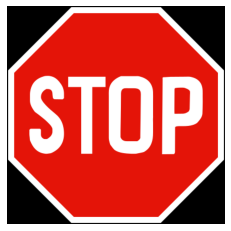

In [21]:
# load mask
stop_mask = load_mask("https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Liberian_Road_Signs_-_Regulatory_Sign_-_Stop.svg/400px-Liberian_Road_Signs_-_Regulatory_Sign_-_Stop.svg.png")

# show mask
plt.imshow(stop_mask)
plt.axis("off")
plt.show()

Then we create and show default wordcloud. In particular, we can color the wordcloud using ImageColorGenerator's image-based coloring technique. It uses the average color of the region occupied by the word in a source image:

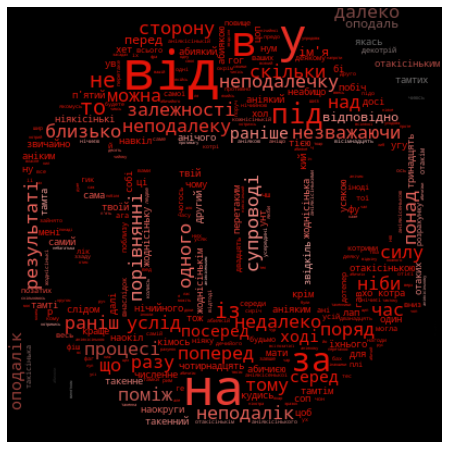

In [22]:
from wordcloud import WordCloud, ImageColorGenerator

# create wordcloud
wordcloud = WordCloud(
    background_color="black",
    mask=stop_mask,
    random_state=42,
    max_font_size=50,
    max_words=1000,
)

wordcloud.generate(' '.join(STOP_WORDS))

image_colors = ImageColorGenerator(stop_mask)

# show wordcloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.show()

<h3 align="center">Stemming</h3>

For grammatical purposes, documents are going to use various forms of a word, such as `швидко`, `швидкий`, `швидкі`. In certain cases, it appears that it would be useful for a search for one of these words to return documents that contain another word in the set. Both stemming and lemmatization have the aim of reducing a word's inflectional and often derivationally related forms to a common base form.

**Stamming** is the process of shortening a word to the base by discarding auxiliary parts, such as endings or suffixes. The results of stemming are sometimes very similar to determining the root of a word, but its algorithms are based on other principles. Therefore, the word after processing by the algorithm of steming (stematization) may differ from the morphological root of the word.

*Example*: 

*`бігом`*, *`бігаю`*, *`бігати`* → **`біг`**

*`швидко`*, *`швидкий`*, *`швидкі`* → **`швидк`**

For good we would use `PorterStemmer` from `nltk.stem`, but for obvious reasons we can't. But this is not a problem, because writing your own `PorterStemmer` realization is not so difficult, so we can just import it. Our stemmer was developed for Python based on this: https://github.com/teamtnt/tntsearch/blob/master/src/Stemmer/UkrainianStemmer.php

In [24]:
from stemmer_ua import UAStemmer

def stem_words(words):
    return [UAStemmer(word).stem_word() for word in words]

stemmed_words = stem_words(filtered_words)
print(stemmed_words)

['я', 'замовля', 'копі', '23', 'директор', 'середн', 'шкіл', 'помічник', 'директор', ',', 'ведут', 'прогр', 'середн', 'школ', 'систем', 'державн', 'шкіл', 'мілуок', '.', 'ми', 'використовуватимем', 'книг', 'вітл', 'основн', 'ресурс', 'професійн', 'зростанн', 'спільн', 'інститут', 'керівник', 'середн', 'школ', 'mps', '9-11', 'серпн', '1999', 'р.', 'ми', 'зацікавлен', 'реформ', ';', 'прагнем', 'оновленн', '.', 'вітл', 'забезпеч', 'основ', '.', 'вон', 'зазнач', ',', 'ейнштейн', ',', 'проблем', 'вирішит', 'тіє', 'свідомост', ',', 'створил', '.', 'вся', 'книг', 'дивовижн', 'дослідженн', 'філософі']


<h3 align="center">Lemmatizing</h3>

<cite><b>Lemmatization</b>, unlike <b>Stemming</b>, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called <b>Lemma</b>. A lemma is the canonical form, dictionary form, or citation form of a set of words.</cite>

At lematization the word loses inflectional endings and finds the basic form. For example, the noun `[плечима — плече]`, the verb `[ходили — ходити]`, the adjective `[смішним — смішний]`.

Python `NLTK` provides `WordNet Lemmatizer` that uses the `WordNet Database` to lookup lemmas of words. But there is no Ukrainian, after some searching I found that in `pymorphy2` there is support for Ukrainian, actually, at the experimental level (at the time of writing - March 2021), but there is.

To install the library, type in the terminal: `pip install pymorphy2` and  `pip install -U pymorphy2-dicts-uk`

Let's connect the library and see how it works:

In [27]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer(lang='uk')
morph.parse('відчувається')

[Parse(word='відчувається', tag=OpencorporaTag('VERB,Refl,impf sing,3per,pres'), normal_form='відчуватися', score=1.0, methods_stack=((DictionaryAnalyzer(), 'відчувається', 281, 12),))]

Now let's try the lematizer on our test review:

In [29]:
def lemmatize_words(morph, words):
    return [morph.parse(word)[0].normal_form for word in words]

lemmatized_words = lemmatize_words(morph, filtered_words)
print(lemmatized_words)

['я', 'замовляти', 'копія', '23', 'директор', 'середній', 'школа', 'помічник', 'директор', ',', 'вести', 'програма', 'середній', 'школа', 'система', 'державний', 'школа', 'мілуокі', '.', 'ми', 'використовувати', 'книга', 'вітло', 'основний', 'ресурс', 'професійний', 'зростання', 'спільний', 'інститут', 'керівник', 'середній', 'школа', 'mps', '9-11', 'серпень', '1999', 'р.', 'ми', 'зацікавлений', 'реформа', ';', 'прагнути', 'оновлення', '.', 'вітло', 'забезпечувати', 'основа', '.', 'вона', 'зазначати', ',', 'ейнштейн', ',', 'проблема', 'вирішити', 'той', 'свідомість', ',', 'створити', '.', 'весь', 'книга', 'дивовижний', 'дослідження', 'філософія']


<h3 align="center">Processing of All Reviews</h3>

Now let's start processing all reviews using the methods described above. Lematization is quite a time-consuming procedure, so you have to wait:

In [35]:
# Use regex_tokenizer to get rid of punctuation
words_list = [regex_tokenizer(item) for item in list(reviews['review_text'])]
print("Review without punctuation: ", words_list[1])

# Eliminate stopwords
words_list = [stopwords_elimination(STOP_WORDS, word) for word in words_list]
print("\n\nReview after stopwords elimination: ", words_list[1])

# Lemmatizing
words_list = [lemmatize_words(morph, word) for word in words_list]
print("\n\nReview after lemmatizing: ", words_list[1])

Review without punctuation:  ['Я', 'замовляю', 'копії', 'для', 'всіх', '23', 'директорів', 'середніх', 'шкіл', 'та', 'двох', 'помічників', 'директорів', 'які', 'ведуть', 'дві', 'програми', 'середньої', 'школи', 'в', 'системі', 'державних', 'шкіл', 'Мілуокі', 'Ми', 'використовуватимемо', 'книгу', 'Вітлі', 'як', 'основний', 'ресурс', 'для', 'нашого', 'професійного', 'зростання', 'в', 'нашому', 'спільному', 'інституті', 'керівників', 'середньої', 'школи', 'MPS', '9', '11', 'серпня', '1999', 'р', 'Ми', 'не', 'просто', 'зацікавлені', 'в', 'реформах', 'ми', 'також', 'прагнемо', 'оновлення', 'Вітлі', 'забезпечує', 'основу', 'Вона', 'зазначає', 'що', 'Ейнштейн', 'сказав', 'що', 'проблему', 'не', 'можна', 'вирішити', 'з', 'тієї', 'самої', 'свідомості', 'яка', 'її', 'створила', 'Вся', 'книга', 'є', 'дивовижним', 'дослідженням', 'цієї', 'філософії']


Review after stopwords elimination:  ['Я', 'замовляю', 'копії', '23', 'директорів', 'середніх', 'шкіл', 'помічників', 'директорів', 'ведуть', 'прог